In [ ]:
import zipfile
import os

zip_path = "/content/data.zip"

# Create a directory
extract_path = "/content/extracted_data"
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

import os
for root, dirs, files in os.walk(extract_path):
    print("Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])  # show a few files
    break

Folder: /content/extracted_data
Subfolders: ['data']
Files: []


In [ ]:
import os

data_path = "/content/extracted_data/data"

for root, dirs, files in os.walk(data_path):
    print("Current Folder:", root)
    print("Subfolders:", dirs)
    print("Files:", files[:5])  # show first 5 files
    print("="*50)
    
    break


Current Folder: /content/extracted_data/data
Subfolders: ['green_area', 'cloudy', 'water', 'desert']
Files: []


In [ ]:
import cv2
import numpy as np
import os


dataset_path = "/content/extracted_data/data"

features = []
labels = []


for label in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, label)
    if not os.path.isdir(class_dir):
        continue

   
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)

        # Read image
        image = cv2.imread(img_path)
        if image is None:
            continue

        
        image = cv2.resize(image, (128, 128))

        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # color histogram
        hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                            [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(hist)
        labels.append(label)


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Convert to NumPy
X = np.array(features)
y = np.array(labels)

# Encode class names to numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# SVM Model
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


SVM Classification Report:
              precision    recall  f1-score   support

      cloudy       0.98      0.96      0.97       300
      desert       0.96      0.99      0.97       227
  green_area       0.82      0.89      0.85       300
       water       0.87      0.79      0.83       300

    accuracy                           0.90      1127
   macro avg       0.91      0.91      0.91      1127
weighted avg       0.90      0.90      0.90      1127

Random Forest Classification Report:
              precision    recall  f1-score   support

      cloudy       0.99      0.99      0.99       300
      desert       1.00      1.00      1.00       227
  green_area       0.90      0.91      0.91       300
       water       0.91      0.90      0.90       300

    accuracy                           0.95      1127
   macro avg       0.95      0.95      0.95      1127
weighted avg       0.95      0.95      0.95      1127



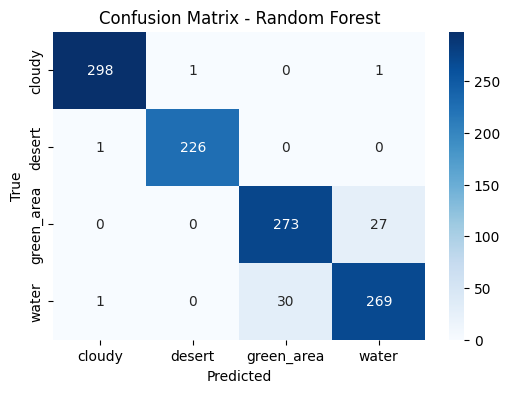

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Random Forest')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pickle
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder

# Feature extraction
def extract_color_histogram(image):
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Extracting color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


def extract_lbp_features(image, P=8, R=1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

# Combine with color histograms
features = []
labels = []
dataset_path = "/content/extracted_data/data"

for label, folder in enumerate(['green_area', 'cloudy', 'water', 'desert']):
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            color_features = extract_color_histogram(image)
            lbp_features = extract_lbp_features(image)
            combined = np.concatenate([color_features, lbp_features])
            features.append(combined)
            labels.append(label)

X = np.array(features)
y = np.array(labels)


# defining parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

# Initialize model
svc = SVC()

# Grid search
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X, y)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

best_model = grid.best_estimator_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy with best parameters:", test_accuracy)

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('label_map.pkl', 'wb') as f:
    pickle.dump(le, f)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9944947289287173
Test Accuracy with best parameters: 0.997338065661047


In [ ]:
from skimage.feature import local_binary_pattern
import cv2
import numpy as np
import os

def extract_color_histogram(image):
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


def extract_lbp_features(image, P=8, R=1):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize
    return hist

features = []
labels = []
dataset_path = "/content/extracted_data/data"

for label, folder in enumerate(['green_area', 'cloudy', 'water', 'desert']):
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        if image is not None:
            color_features = extract_color_histogram(image)
            lbp_features = extract_lbp_features(image)
            combined = np.concatenate([color_features, lbp_features])
            features.append(combined)
            labels.append(label)

In [9]:
from google.colab import files

# Download model and label map
files.download('best_model.pkl')
files.download('label_map.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import LabelEncoder
import pickle # Changed from joblib to pickle


with open("best_model.pkl", "rb") as f: # Changed from joblib to pickle
    model = pickle.load(f)
with open("label_map.pkl", "rb") as f: # Changed from joblib to pickle
    label_encoder = pickle.load(f)

print(f"Model expects {model.n_features_in_} features.")


RADIUS = 1
N_POINTS = 8 * RADIUS

# feature extraction
def extract_features(image):
    image = cv2.resize(image, (128, 128))

    # Color histogram (HSV)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                        [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()

    # LBP
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, N_POINTS, RADIUS, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, N_POINTS + 2), range=(0, N_POINTS + 1)) # Adjusted bin range
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    features = np.hstack([hist, lbp_hist]) # Combined color histogram and LBP features
    return features.reshape(1, -1)


test_folder = "/content/extracted_data/data"  # Change path if needed

for category in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, category)
    if not os.path.isdir(folder_path): # Added check if it is a directory
        continue
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        features = extract_features(img)
        print(f"Extracted {features.shape[1]} features for image {img_name}")
        pred = model.predict(features)[0]
        label = label_encoder.inverse_transform([pred])[0]
        print(f"Image: {img_name}, Actual: {category}, Predicted: {label}")

Model expects 522 features.
Extracted 521 features for image Forest_66.jpg


ValueError: X has 521 features, but SVC is expecting 522 features as input.